In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# fashion mnist dataset을 통한 딥러닝 학습 실습을 정리하기 위한 공간임

* 일반적으로 로직은
* functional api 모델 생성 후 pixel 값 조정 및 type 조정
* one hot encoding 적용
* 이후 학습 검증 테스트 데이터로 나눈다
* 마지막으로 complie, 학습/예측/평가

## 데이터 전처리 수행

* 0에서 255 사이의 픽셀값을 0에서 1 사이로 변환. 이 과정을 거쳐야 성능 향상
* array type은 float32. tensorflow도 데이터를 끌어올 떄 자동적으로 float32로 바꾼다
* 전처리를 수행하기 전에 train_labels를 보면 type이 unit8로 되어 있음

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 전처리를 수행하기 전 데이터들을 보면 type이 unit8임
print(type(train_images[0][0][0]))
print(train_images.shape)

2024-02-05 12:14:38.375899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 12:14:38.376030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 12:14:38.534644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4422102/4422102 [==============================] - 0s 0us/step
<class 'numpy.uint8'>
(60000, 28, 28)


In [3]:
print(test_images.shape)

(10000, 28, 28)


Text(0.5, 1.0, '9')

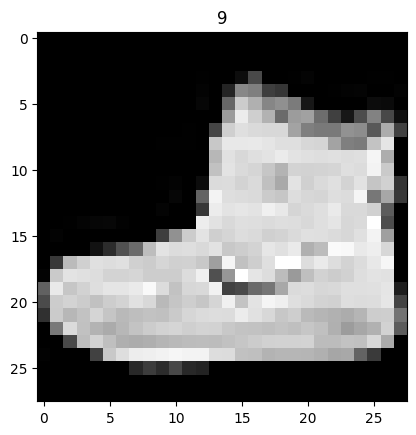

In [4]:
# fashion mnist 데이터 샘플 출력

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])

In [5]:
# functional api를 이용한 model 생성

from tensorflow.keras.layers import  Layer, Input, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    # functional api의 경우 multi input output을 지원하는데 sequentail은 불가능
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 데이터 전처리 함수

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 0~1 사잇값의 float32로 전처리

def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사잇값 float32로 변경하는 함수 호출 후 one hot encoding 적용

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    
    # labels 데이터를 one hot encoding
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 one hot encoding 적용
# 여기서 전처리 및 one hot encoding 과정을 거친 후 학습과 검증 데이터를 분리하면 효율적

def get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):
    
    # 학습과 테스트 데이터의 전처리 후 학습이랑 검증 데이터 분리
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습과 검증 데이터 분리
    train_images, valid_images, train_oh_images, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (train_images, train_oh_images), (valid_images, valid_oh_labels), (test_images, test_oh_labels)

In [7]:
# 데이터 전처리 함수를 활용한 실제 데이터 전처리

from tensorflow.keras.datasets import fashion_mnist

# fashion mnist 데이터 재 로딩 및 전처리 적용해서 학습/검증/테스트 데이터 세트 결정
# 데이터 받아오기 / 처음 받아오는 데이터 타입은 numpy.ndarray이다

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(type(train_labels))

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42)

print((tr_images.shape, tr_oh_labels.shape))  # labels를 보면 one hot encoding이 되어 있다

<class 'numpy.ndarray'>
((51000, 28, 28), (51000, 10))


# loss와 optimizer 설정을 통한 학습 수행
* loss는 categorical_crossentropy로, optimizer는 Adam으로 설정
* categorical crossentropy를 위해서 Label을 one hot encoding으로 변경(keras의 to_categorical을 통해)

In [8]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용

model = create_model()
model.summary()

# compile을 통해 loss 함수와 optimizer 설정
# one hot encoding이 되었으면 categorical, 아닌 경우 sparse categorical
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 학습 수행의 경우 model의 fit을 통해 진행
# history를 통해 결과를 받는다. loss와 accuracy metrics를 받는다
# epoch를 통해 6만개를 batch 수만큼 쪼개서 학습하는데 이걸 epoch 횟수만큼 반복

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20


I0000 00:00:1707135297.819906      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 [==============================] - 4s 4ms/step - loss: 0.6067 - accuracy: 0.7928 - val_loss: 0.5000 - val_accuracy: 0.8300
Epoch 2/20
399/399 [==============================] - 1s 4ms/step - loss: 0.4133 - accuracy: 0.8531 - val_loss: 0.4310 - val_accuracy: 0.8484
Epoch 3/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3704 - accuracy: 0.8673 - val_loss: 0.3671 - val_accuracy: 0.8697
Epoch 4/20
399/399 [==============================] - 1s 4ms/step - loss: 0.3439 - accuracy: 0.8767 - val_loss: 0.3708 - val_accuracy: 0.8681
Epoch 5/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8829 - val_loss: 0.3645 - val_accuracy: 0.8657
Epoch 6/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3080 - accuracy: 0.8890 - val_loss: 0.3508 - val_accuracy: 0.8740
Epoch 7/20
399/399 [==============================] - 2s 4ms/step - loss: 0.2965 - accuracy: 0.8923 - val_loss: 0.3382 - val_accuracy: 0.8790
Epoch 8/20
399/39

In [10]:
history.history

{'loss': [0.6066997647285461,
  0.4132612347602844,
  0.3703814446926117,
  0.34393566846847534,
  0.3245497941970825,
  0.30797460675239563,
  0.29651784896850586,
  0.2844993770122528,
  0.2754538953304291,
  0.2652904689311981,
  0.2572615146636963,
  0.248806893825531,
  0.24312393367290497,
  0.23547670245170593,
  0.23301392793655396,
  0.22635948657989502,
  0.21934938430786133,
  0.21777939796447754,
  0.21084721386432648,
  0.2030973881483078],
 'accuracy': [0.7927843332290649,
  0.8531372547149658,
  0.867254912853241,
  0.8767451047897339,
  0.8828823566436768,
  0.8890196084976196,
  0.8922744989395142,
  0.8970588445663452,
  0.8986862897872925,
  0.9034509658813477,
  0.9056470394134521,
  0.9093921780586243,
  0.9119411706924438,
  0.9130980372428894,
  0.9148823618888855,
  0.9169019460678101,
  0.9193333387374878,
  0.9187647104263306,
  0.921999990940094,
  0.9244117736816406],
 'val_loss': [0.49998849630355835,
  0.4310189187526703,
  0.3671124577522278,
  0.37084728

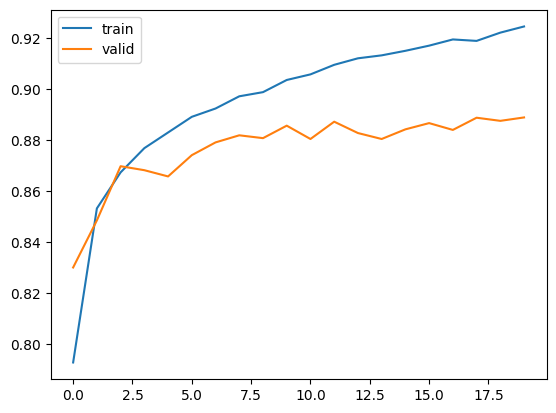

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(hisotry):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [12]:
# 테스트 세트로 모델 성능 검증

model.evaluate(x=test_images, y=test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 3ms/step - loss: 0.3453 - accuracy: 0.8838


[0.3452639579772949, 0.8838000297546387]

## callback
* 학습 iteration을 수행할 때 특정 event가 발생하는 경우 호출하는 기능들
* 대표적으로 ModelCheckpoint(), ReduceLROnPlateau(), LearningRateScheduler(), EarlyStopping(), TensorBoard 등이 있음

### ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

* 특정 조건에 맞춰서 모델을 파일에 저장
* filepath: filepath의 경우 on epoch end에서 전달되는 epoch 값과 logs의 키로 채워진 이름 형식 옵션을 가질 수 있다. 예를 들어 filepath가 weights.{epoch:02d}-{val_loss:.2f}.hdf5d인 경우, 파일 이름에 세대 번호와 검증 손실을 넣어 모델의 체크포인트가 저장된다
* monitor: 모니터할 지표(loss 또는 평가 지표) / 대표적으론 val_loss, val_accuracy
* save_best_only: 가장 좋은 성능을 나타내는 모델만 저장할 여부
* save_weights_only: weights만 저장여부 / 성능 및 버그 감소를 위해 True로 두는 것이 좋고, save weights를 통해 저장된 값은 load weights를 통해 다시 불러오면 된다
* mode: {auto, min, max} 중 하나. monitor 지표가 감소해야 좋을 경우, 증가해야 좋은 경우를 구분해서 입력하면 된다. auto로 두면 알아서 분류해주긴 하는데 간혹 틀린 경우가 있어 직접 명시적으로 지정해주는 것이 좋다.
* periods를 길게 설정하면 save weights 같은 작업 반복 주기를 늘릴 수 있다.

In [13]:
# 현재 dir 위치
!pwd

/kaggle/working


In [14]:
# 참고로 keras의 metrics(메트릭이라고 부르기도 함)은 평가지표를 의미한다

from tensorflow.keras.callbacks import ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_ob = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                        save_best_only=True, save_weights_only=True, mode='min', periods=3, verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=10, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_ob])

Epoch 1/10
388/399 [============================>.] - ETA: 0s - loss: 0.5583 - accuracy: 0.7993
Epoch 1: val_loss improved from inf to 0.47894, saving model to /kaggle/working/weights.01-0.48.hdf5
399/399 [==============================] - 3s 4ms/step - loss: 0.5547 - accuracy: 0.8009 - val_loss: 0.4789 - val_accuracy: 0.8284
Epoch 2/10
394/399 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8535
Epoch 2: val_loss improved from 0.47894 to 0.43666, saving model to /kaggle/working/weights.02-0.44.hdf5
399/399 [==============================] - 1s 4ms/step - loss: 0.4038 - accuracy: 0.8537 - val_loss: 0.4367 - val_accuracy: 0.8460
Epoch 3/10
395/399 [============================>.] - ETA: 0s - loss: 0.3750 - accuracy: 0.8634
Epoch 3: val_loss improved from 0.43666 to 0.38733, saving model to /kaggle/working/weights.03-0.39.hdf5
399/399 [==============================] - 1s 4ms/step - loss: 0.3747 - accuracy: 0.8634 - val_loss: 0.3873 - val_accuracy: 0.8658
Epoch 4/

In [15]:
# 위 과정을 통해 save best only option으로 인해 여러개의 파이이 만들어진다

!ls -lia

!rm -rf weight*
!ls -lia

total 2084
  1048584 drwxr-xr-x 2 root root   4096 Feb  5 12:15 .
268744977 drwxr-xr-x 6 root root   4096 Feb  5 12:14 ..
  1048585 ---------- 1 root root 384649 Feb  5 12:15 __notebook__.ipynb
  1048586 -rw-r--r-- 1 root root 344080 Feb  5 12:15 weights.01-0.48.hdf5
  1048587 -rw-r--r-- 1 root root 344080 Feb  5 12:15 weights.02-0.44.hdf5
  1048588 -rw-r--r-- 1 root root 344080 Feb  5 12:15 weights.03-0.39.hdf5
  1048589 -rw-r--r-- 1 root root 344080 Feb  5 12:15 weights.04-0.38.hdf5
  1048590 -rw-r--r-- 1 root root 344080 Feb  5 12:15 weights.06-0.36.hdf5
total 384
  1048584 drwxr-xr-x 2 root root   4096 Feb  5 12:15 .
268744977 drwxr-xr-x 6 root root   4096 Feb  5 12:14 ..
  1048585 ---------- 1 root root 384649 Feb  5 12:15 __notebook__.ipynb


### ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
* 특정 epoch 횟수 동안 성능이 개선되지 않을 시 learning rate를 동적으로 감소시킨다
* monitor: 모니터할 지표로, loss 또는 여러 평가 지표
* factor: 학습 속도를 줄일 인수, new_lr = lr(기존 learning rate) * factor
* patience: Learning rate를 줄이기 전에 monitor할 epochs 횟수
* mode: auto, min, max 중 하나

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitors='val_loss', factor=0.3, patience=3, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[rlr_cb])

Epoch 1/30
399/399 [==============================] - 3s 4ms/step - loss: 0.5896 - accuracy: 0.7983 - val_loss: 0.4395 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 2/30
399/399 [==============================] - 1s 4ms/step - loss: 0.4144 - accuracy: 0.8527 - val_loss: 0.4016 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3671 - accuracy: 0.8701 - val_loss: 0.3792 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 4/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3424 - accuracy: 0.8756 - val_loss: 0.3607 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 5/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3230 - accuracy: 0.8826 - val_loss: 0.3521 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 6/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3018 - accuracy: 0.8895 - val_loss: 0.3530 - val_accuracy: 0.8726 - lr: 0.0010
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - lo

### EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
* 특정 epochs 동안 성능이 개선되지 않을 시 학습을 조기에 중단
* monitor: 모니터할 지표
* patience: early stopping 적용 전에 monitor할 epochs 횟수
* mode: auto min max 중 선택

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[ely_cb])

Epoch 1/30
399/399 [==============================] - 3s 4ms/step - loss: 0.5862 - accuracy: 0.7990 - val_loss: 0.4540 - val_accuracy: 0.8413
Epoch 2/30
399/399 [==============================] - 1s 4ms/step - loss: 0.4077 - accuracy: 0.8562 - val_loss: 0.4179 - val_accuracy: 0.8526
Epoch 3/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3692 - accuracy: 0.8681 - val_loss: 0.3764 - val_accuracy: 0.8660
Epoch 4/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3465 - accuracy: 0.8755 - val_loss: 0.3672 - val_accuracy: 0.8660
Epoch 5/30
399/399 [==============================] - 2s 4ms/step - loss: 0.3217 - accuracy: 0.8832 - val_loss: 0.3567 - val_accuracy: 0.8731
Epoch 6/30
399/399 [==============================] - 1s 4ms/step - loss: 0.3059 - accuracy: 0.8893 - val_loss: 0.3517 - val_accuracy: 0.8718
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - loss: 0.2967 - accuracy: 0.8914 - val_loss: 0.3502 - val_accuracy: 0.8796
Epoch 

In [18]:
!rm weigh*

rm: cannot remove 'weigh*': No such file or directory


In [19]:
# 보통은 위 callback들을 따로 쓰지 않고 한번에 다같이 쓴다

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=40, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
399/399 [==============================] - 3s 4ms/step - loss: 0.6100 - accuracy: 0.7931 - val_loss: 0.4632 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 2/40
399/399 [==============================] - 1s 4ms/step - loss: 0.4176 - accuracy: 0.8520 - val_loss: 0.4007 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 3/40
399/399 [==============================] - 1s 4ms/step - loss: 0.3740 - accuracy: 0.8675 - val_loss: 0.4108 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 4/40
399/399 [==============================] - 1s 4ms/step - loss: 0.3481 - accuracy: 0.8747 - val_loss: 0.3799 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 5/40
399/399 [==============================] - 1s 4ms/step - loss: 0.3273 - accuracy: 0.8822 - val_loss: 0.3587 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 6/40
399/399 [==============================] - 1s 4ms/step - loss: 0.3118 - accuracy: 0.8860 - val_loss: 0.3535 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 7/40
399/399 [==============================] - 1s 4ms/step - lo

# Convolutional Neural Network를 통한 feature extraction

### Conv2D를 통한 구현
* 위에서 구현한 일반 dense layer만을 이용한 이미지 classification시에 생기는 문제가 2가지가 있다
* 먼저 분류 대상이 이미지의 어디에 있을지 알 수 없다
* 이미지의 크기가 클수록 이를 위한 너무 많은 weight가 필요하다
* 이를 위해 고안된 방식이 convolutional neural network를 통한 feature extracting 방식이고, keras에선 이를 layers의 Conv2D를 통해 구현한다.

In [20]:
# Conv2D 구현 예시

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

# 이전에 만들었던 model의 input tensor에서 봤듯이 keras에서 모델 생성 시 batch를 고려하지 않았다.
# 그래서 우리도 2차원 배열을 shape로 넣어줬다
# 그러나 keras layer의 conv2d는 batch를 제외하고도 3차운을 받는다. 이는 shape에서 channel의 공간을 고려했기 때문이다.
# 해당 channel의 경우 tensorflow는 channel 정보를 무조건 뒤에서 받기 때문이다.
input_tensor = Input(shape=(28,28,1))

# padding 옵션의 경우, same이면 con2d 연산 전후 사이즈가 28*28로 갖게 맞춰진다.
x = Conv2D(filters=4, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)

conv2d_model = Model(inputs=input_tensor, outputs=x)
conv2d_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Pooling 적용하기
* pooling이란, 앞서서 conv2d layer의 계산 결과인 feature maps를 일종의 subsampling하는 과정이다.

#### Pooling의 목적은 아래와 같다
1. input size를 줄여 텐서의 크기를 줄여 계산 속도를 높이기.
2. input size 감소를 통한 불필요한 parameter 제거로 overfitting 조절

In [21]:
# pooling을 적용한 모델 구현 예시

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# maxpooling2d를 통해 channel의 수는 변하지 않고 평면적인 사이즈는 28*28에서 14*!4로 축소

input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)
print(x)

pooling_model = Model(inputs=input_tensor, outputs=x)
# summary에서 maxpooling의 경우 기존에 있는 feature map에 연산을 통해 shape를 줄이는 역할을 수행했기에 parameter는 따로 없다
# 첫 번째 conv2d에서 param수가 160인 이유는 kernel_size 3*3이 16개가 있고, 거기에 bias가 filter 개수만큼 붙어서 (3*3)*16 + 16 = 160이다.
# 두 번째 conv2d의 pararm수는 한 filter에 3*3으로 구성된 kernel이 16개가 있다. 그렇게 구성된 filter가 32개가 있고 여기에 bias 32개가 붙어서 (3*3*16)*32 + 32 = 4640이다.
# 결국 위처럼 구성된 cnn의 연산을 거쳐서 최적 feature 추출을 위한 필터 weight 값이 계산된다.
pooling_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13, 32), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
Total params: 4800 (18.75 KB)
Trainable params: 4800 (18.75 KB)
Non-trainable params: 0 

# feature extractor와 classifier를 합친 model 생성

In [22]:
from tensorflow.keras.layers import  Input,Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# feature extractor
input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

# classifier
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 10816)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               1081700   
                                                           

## fashion mnist 데이터를 사용한 모델 학습 및 평가

In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20
399/399 [==============================] - 7s 9ms/step - loss: 0.4435 - accuracy: 0.8423 - val_loss: 0.3320 - val_accuracy: 0.8800
Epoch 2/20
399/399 [==============================] - 3s 7ms/step - loss: 0.2708 - accuracy: 0.9025 - val_loss: 0.2664 - val_accuracy: 0.9060
Epoch 3/20
399/399 [==============================] - 3s 8ms/step - loss: 0.2174 - accuracy: 0.9202 - val_loss: 0.2330 - val_accuracy: 0.9134
Epoch 4/20
399/399 [==============================] - 3s 8ms/step - loss: 0.1793 - accuracy: 0.9341 - val_loss: 0.2230 - val_accuracy: 0.9161
Epoch 5/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1458 - accuracy: 0.9467 - val_loss: 0.2406 - val_accuracy: 0.9159
Epoch 6/20
399/399 [==============================] - 3s 7ms/step - loss: 0.1220 - accuracy: 0.9549 - val_loss: 0.2320 - val_accuracy: 0.9177
Epoch 7/20
399/399 [==============================] - 3s 7ms/step - loss: 0.0956 - accuracy: 0.9655 - val_loss: 0.2357 - val_accuracy: 0.9197
Epoch 

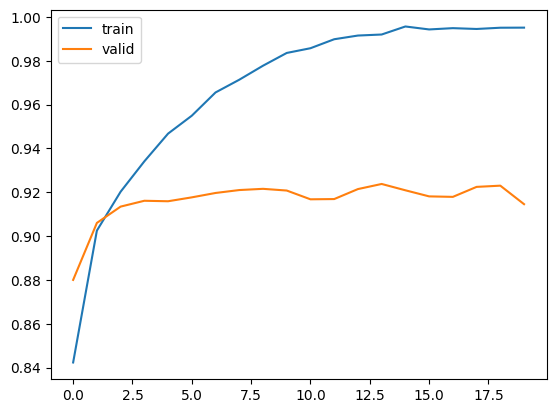

In [25]:
show_history(history)

In [26]:
# 기존에 위에서 feature extraction 과정 없이 진행한 모델에 비해 훨씬 낫다.

model.evaluate(test_images, test_oh_labels, batch_size=128, verbose=1)

79/79 [==============================] - 0s 6ms/step - loss: 0.5289 - accuracy: 0.9108


[0.5288869142532349, 0.9107999801635742]

## Dropout을 적용해서 Fully Connected Layer의 오버피팅 조정
* CNN을 이용해 만든 모델을 만들 때 fully connected layer를 만들 경우 지나치게 많은 파라미터가 생성될 수 있다.
* 이럴 경우 over fitting 문제와 더불어 연산 속도 저하를 불러올 수 있다.
* 이를 dropout을 통해 layer간 연결을 의도적으로 끊어줘 이 문제에 대응할 수 있다.

In [27]:
# dropout의 경우 keras layers의 Dropout을 통해 적용할 수 있다.

from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Dropout(rate=0.5)(x)
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 10816)             0         
                                                           

In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30


2024-02-05 12:18:58.357670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


399/399 [==============================] - 7s 11ms/step - loss: 0.5004 - accuracy: 0.8212 - val_loss: 0.3244 - val_accuracy: 0.8820
Epoch 2/30
399/399 [==============================] - 4s 10ms/step - loss: 0.3394 - accuracy: 0.8763 - val_loss: 0.2773 - val_accuracy: 0.8996
Epoch 3/30
399/399 [==============================] - 4s 10ms/step - loss: 0.2947 - accuracy: 0.8910 - val_loss: 0.2591 - val_accuracy: 0.9054
Epoch 4/30
399/399 [==============================] - 4s 10ms/step - loss: 0.2651 - accuracy: 0.9014 - val_loss: 0.2404 - val_accuracy: 0.9099
Epoch 5/30
399/399 [==============================] - 4s 10ms/step - loss: 0.2473 - accuracy: 0.9077 - val_loss: 0.2219 - val_accuracy: 0.9186
Epoch 6/30
399/399 [==============================] - 4s 10ms/step - loss: 0.2286 - accuracy: 0.9149 - val_loss: 0.2118 - val_accuracy: 0.9217
Epoch 7/30
399/399 [==============================] - 4s 10ms/step - loss: 0.2161 - accuracy: 0.9195 - val_loss: 0.2098 - val_accuracy: 0.9212
Epoch 8/30

79/79 [==============================] - 0s 4ms/step - loss: 0.2210 - accuracy: 0.9311


[0.22102008759975433, 0.9311000108718872]

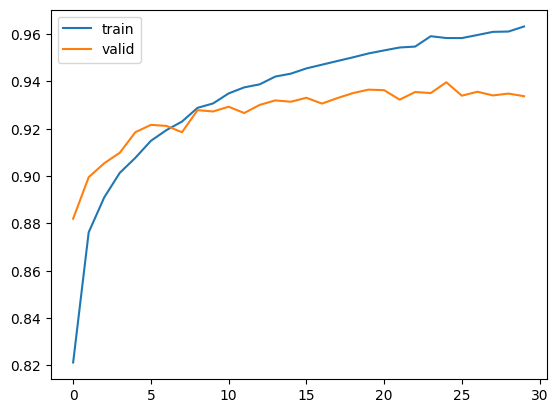

In [29]:
show_history(history)

model.evaluate(x=test_images, y=test_oh_labels, batch_size=128, verbose=1)